In [5]:
import os
import sys
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets
import sklearn as sk
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label


In [6]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.1
Python 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Pandas 2.2.2
Scikit-Learn 1.4.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [2]:
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)


{'ko': 0, 'tsla': 1}


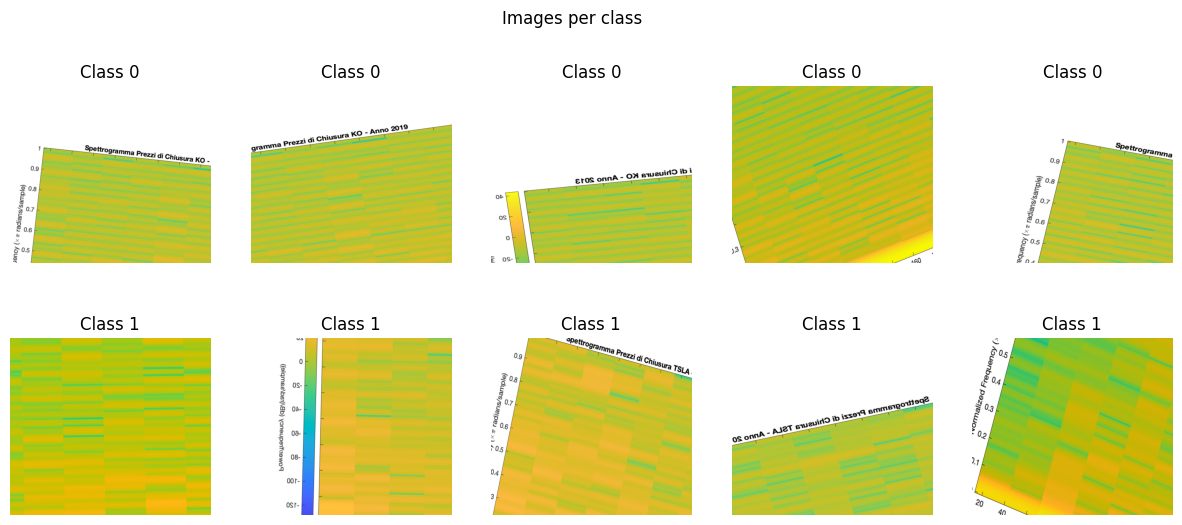

In [3]:
def plot_images_per_class(loader, label_map, num_images=5):
    class_images = {label: {"images": [], "labels": []} for label in label_map.values()}

    for images, labels in loader:
        for image, label in zip(images, labels):
            if label.item() in class_images and len(class_images[label.item()]["images"]) < num_images:
                class_images[label.item()]["images"].append(image)
                class_images[label.item()]["labels"].append(label.item())

    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(15, num_classes * 3))
    fig.suptitle("Images per class")

    for label, data in class_images.items():
        for i in range(num_images):
            if i < len(data["images"]):
                image = data["images"][i].permute(1, 2, 0).numpy()
                image = (image - image.min()) / (image.max() - image.min())
                ax = axes[label, i] if num_classes > 1 else axes[i]
                ax.imshow(image)
                ax.set_title(f"Class {label}")
                ax.axis("off")

    plt.show()

plot_images_per_class(valid_loader, label_map)


In [3]:
def extract_label(image_path):
    try:
        # Extract label from the directory name (e.g., "train/tsla/TSLA_0_2947.png" -> "tsla")
        label = os.path.basename(os.path.dirname(image_path))
        return label
    except Exception as e:
        print(f"Could not extract label from path: {image_path}, error: {e}")
        return None

def count_images_per_class(folder_path):
    labels = []
    for image_path in get_image_paths(folder_path):
        label = extract_label(image_path)
        if label is not None:
            labels.append(label)
        else:
            print(f"Skipping file with unexpected label format: {image_path}")

    if labels:
        return pd.Series(labels).value_counts().sort_index()
    else:
        return pd.Series([], name="count")

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))


ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import copy

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

# Define the Neural Network
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(32*62*62, 128)
        self.fc2 = nn.Linear(128, len(label_map))  # Use the length of label_map

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = SimpleCNN(num_classes=len(label_map)).to(device)

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

    

ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import copy

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

# Define the Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flatten_size(self):
        x = torch.randn(1, 3, 256, 256)  # Example input size
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        print("Shape after conv layers:", x.shape)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instantiate the model and print the flatten size
num_classes = len(label_map)  # Assuming label_map is already defined
model = SimpleCNN(num_classes=num_classes).to(device)
print(f"Flatten size: {model.flatten_size}")
lasses=len(label_map).to(device)

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

# Visualize Results
def visualize_model(model, loader, label_map, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(label_map.keys())[list(label_map.values()).index(preds[j].item())]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, test_loader, label_map)


ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}
Shape after conv layers: torch.Size([1, 64, 30, 30])
Flatten size: 57600


AttributeError: 'int' object has no attribute 'to'

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import copy

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flatten_size(self):
        x = torch.randn(1, 3, 256, 256)  # Example input size
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        print("Shape after conv layers:", x.shape)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_classes = len(label_map)  # Correct assignment
model = SimpleCNN(num_classes=num_classes).to(device)
print(f"Flatten size: {model.flatten_size}")

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

# Visualize Results
def visualize_model(model, loader, label_map, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(label_map.keys())[list(label_map.values()).index(preds[j].item())]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, test_loader, label_map)


ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}
Shape after conv layers: torch.Size([1, 64, 30, 30])
Flatten size: 57600


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x307840 and 57600x128)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import copy

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

# Define functions to get image paths and data loaders
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_flatten_size(self):
        x = torch.randn(1, 3, 256, 256)  # Example input size
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        print("Shape after conv layers:", x.shape)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_classes = len(label_map)  # Correct assignment
model = SimpleCNN(num_classes=num_classes).to(device)
print(f"Flatten size: {model.flatten_size}")

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

# Visualize Results
def visualize_model(model, loader, label_map, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(label_map.keys())[list(label_map.values()).index(preds[j].item())]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, test_loader, label_map)


ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}
Shape after conv layers: torch.Size([1, 64, 30, 30])
Flatten size: 57600


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x307840 and 57600x128)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import copy

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

# Define functions to get image paths and data loaders
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

# Define the CNN model with adaptive pooling
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive pooling to ensure fixed size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.adaptive_pool(out)  # Apply adaptive pooling
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_classes = len(label_map)  # Correct assignment
model = SimpleCNN(num_classes=num_classes).to(device)

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

# Visualize Results
def visualize_model(model, loader, label_map, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(label_map.keys())[list(label_map.values()).index(preds[j].item())]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, test_loader, label_map)


ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}


RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes.

ko      947
tsla    948
Name: count, dtype: int64
ko      10
tsla    10
Name: count, dtype: int64
{'ko': 0, 'tsla': 1}
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv layers: torch.Size([64, 64, 65, 74])
Shape after adaptive pool: torch.Size([64, 64, 7, 7])
Shape after conv 

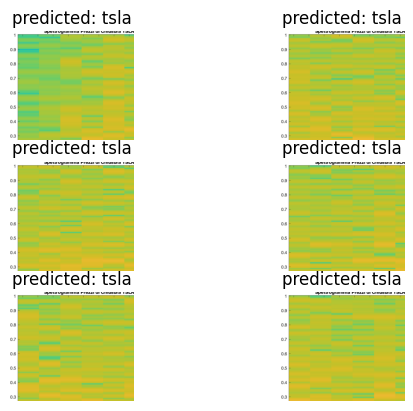

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import copy

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations
        self.label_map = self._create_label_map(image_paths)

    def _create_label_map(self, image_paths):
        labels = set()
        for path in image_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.add(label)
        label_map = {label: idx for idx, label in enumerate(sorted(labels))}
        return label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_str = os.path.basename(os.path.dirname(image_path))
        label = self.label_map[label_str]
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

# Define functions to get image paths and data loaders
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

def get_train_valid_loader(batch_size=64, valid_size=0.2, shuffle=True, random_seed=42):
    transform = transforms.Compose([transforms.ToTensor()])
    train_image_paths = get_image_paths(TRAIN_DATA_PATH)
    num_train = len(train_image_paths)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_dataset = CustomDataset(train_image_paths, transform=transform)
    valid_dataset = CustomDataset(train_image_paths, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    test_image_paths = get_image_paths(TEST_DATA_PATH)
    test_dataset = CustomDataset(test_image_paths, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Paths to your datasets
TRAIN_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train'
TEST_DATA_PATH = '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test'

# Example usage
print(count_images_per_class(TRAIN_DATA_PATH))
print(count_images_per_class(TEST_DATA_PATH))

train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

# Verify label map
sample_dataset = CustomDataset(get_image_paths(TRAIN_DATA_PATH))
label_map = sample_dataset.label_map
print(label_map)

# Define the CNN model with debugging prints
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive pooling to ensure fixed size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        print("Shape after conv layers:", out.shape)
        out = self.adaptive_pool(out)  # Apply adaptive pooling
        print("Shape after adaptive pool:", out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_classes = len(label_map)  # Correct assignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)

# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

# Visualize Results
def visualize_model(model, loader, label_map, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(label_map.keys())[list(label_map.values()).index(preds[j].item())]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                plt.imshow(img)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, test_loader, label_map)
